In [1]:
import os
import email
import re
import mailparser
import random
import spacy
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from bs4 import BeautifulSoup
from tld import get_tld
from time import strftime, strptime, time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, recall_score
from itertools import product
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC 
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier

Set constants for directories, take a random sampling of the "ignore" email since there are so many (under sample)

In [2]:
IGNORE_DIR = '/Users/worshamn/Documents/emailProject/IgnoreFix'
INVESTIGATE_DIR = '/Users/worshamn/Documents/emailProject/InvestigateFix'
#https://stackoverflow.com/a/6482922
random.seed(2842)
ignore_sample_index = [ i for i in sorted(random.sample(range(len(os.listdir(IGNORE_DIR))), 400)) ]
ignore_sample = []
for i in ignore_sample_index:
    ignore_sample.append(os.listdir(IGNORE_DIR)[i])
input_dirs = {}
input_dirs[INVESTIGATE_DIR] = os.listdir(INVESTIGATE_DIR) 
input_dirs[IGNORE_DIR] = ignore_sample

In [3]:
ignore_sample

['[Phish Alert] FW- Barbara.jones shrink your belly, 1lb day.eml',
 '[Phish Alert] FW- 9 Signs You’re Successful—Even If It Doesn’t Feel Like It.eml',
 '[Phish Alert] FW- Watch us print human tissue-organs.eml',
 '[Phish Alert] FW- Share your thoughts, Sara.eml',
 '[Phish Alert] FW- [Spam] NEW! Azure This Month.eml',
 '[Phish Alert] FW- 5 Reasons Companies Love Surface Pro.eml',
 '[Phish Alert] FW- Wells Fargo Wants Your Input on the Custom Credit Offer! - Reminder.eml',
 '[Phish Alert] FW- [Spam] RE- Couple questions go-forward.eml',
 '[Phish Alert] FW- Quality Pet Food Delivered.eml',
 '[Phish Alert] FW- Get the most out of your lectures.eml',
 '[Phish Alert] FW- Imagine Speaking a New Language in Just 30 Days - Free Trial.eml',
 '[Phish Alert] FW- Now’s the Time to Act – Dedicated Servers at Excellent Prices.eml',
 '[Phish Alert] FW- Fw-  to Steve Lindell.eml',
 '[Phish Alert] FW- An invitation to support \uf020My Family Is In Need Of A Blessing\uf020.eml',
 '[Phish Alert] FW- My de

len(input_dirs)

In [4]:
len(input_dirs[INVESTIGATE_DIR])

384

In [5]:
len(input_dirs[IGNORE_DIR])

400

Build function to extract text and features

In [6]:
def get_email_text(file):
    d = {}
    raw_message = email.message_from_file(file)
    mail = mailparser.parse_from_string(raw_message.as_string())
    d['subject'] = mail.subject
    d['subject_len'] = len(d['subject'])
    if raw_message.is_multipart():
        d['is_mulitpart'] = 1
    else:
        d['is_multipart'] = 0
    d['body'] = mail.text_plain
    if len(d['body']) > 0:
        d['mail_text'] = d['subject'] + ' ' + d['body'][0]
        d['body_len'] = len(d['body'][0])
        if len(d['body']) > 1:
            soup_html = BeautifulSoup(d['body'][1],'lxml')
            d['links'] = soup_html.find_all('a')
            d['num_link'] = len(d['links'])
            links = []
            d['masq_link'] = []
            d['masq_link_tld'] = []
            d['num_email_link'] = 0
            for link in d['links']:
                link_text = link.get_text().rstrip('\n')
                a_link = link.get('href')
                links.append(a_link)
                if 'unsubscribe' in link_text.lower():
                    d['has_unsubscribe_link'] = 1
                if a_link:    
                    if re.search('mailto:',a_link):
                        d['num_email_link'] += 1
                if a_link != link_text and \
                    'http' in link_text.lower() and \
                    not 'alt="http' in link_text.lower():
                        d['masq_link'].append(link)
                        d['masq_link_tld'].append(
                            get_tld(
                                a_link,
                                fix_protocol=True, 
                                fail_silently=True
                            )
                        )
            d['num_uniq_link'] = len(set(links))
            if d['num_link'] > d['num_uniq_link']:
                d['has_repeatlink'] = 1
            else:
                d['has_repeatlink'] = 0
            if len(d['masq_link']) == 0:
                d['masq_link'] = ''
                d['masq_link_tld'] = ''
                d['has_masq_link'] = 0
            else:    
                d['has_masq_link'] = 1
                d['num_masq_link'] = len(d['masq_link'])
    else:
        d['mail_text'] = d['subject']
        d['body_len'] = len(d['body'])
    url_query = '((?:https?|ftp)://[^\s/$.?#]+\.[^\s>]+)'
    d['url'] = re.findall(url_query,d['mail_text'])
    email_query = '([\w.]+@[\w.]+\.[\w.]{2,5})'
    d['email'] = re.findall(email_query,d['mail_text'])
    if d['url']:
        d['has_url'] = 1
        d['num_url'] = len(d['url'])
        d['num_uniq_url'] = len(set(d['url']))
        d['num_url_repeats'] = d['num_url'] - d['num_uniq_url']
        d['url_len'] = []
        d['url_tld'] = []
        for i in d['url']:
            d['url_len'].append(len(i))
            d['url_tld'].append(
                get_tld(i, fix_protocol=True, fail_silently=True)
            )
            d['uniq_url_tld'] = set(d['url_tld'])
    else:
        d['url'] = ''
        d['has_url'] = 0
        d['num_url'] = 0
        d['num_uniq_url'] = 0
        d['url_len'] = 0
        d['url_tld'] = 0
        d['uniq_url_tld'] = 0
        d['num_url_repeats'] = 0
    if d['email']:
        d['has_email'] = 1
        d['num_email_addr'] = len(d['email'])
        d['num_uniq_email'] = len(set(d['email']))
    else:
        d['email'] = ''
        d['has_email'] = 0
        d['num_email_addr'] = 0
        d['num_uniq_email'] = 0
    soup = BeautifulSoup(d['mail_text'],'lxml')
    try:
        d['mail_text'] = soup.get_text().encode(
            'utf-8',
            'ignore'
        ).decode('unicode_escape').replace('\n',' ').replace('\t',' ')
    except:
        d['mail_text'] = soup.get_text().replace('\n',' ').replace('\t',' ')
    d['reply_to'] = mail.reply_to
    for k,v in mail.headers.items():
        d[k] = v
    d['body'] = mail.body
    d['text_plain'] = mail.text_plain
    if mail.attachments:
        d['has_attachments'] = 1
        d['num_attachments'] = len(mail.attachments)
        for i in mail.attachments:
            try:
                d['attachment_filename'].append(i['filename'])
            except:
                d['attachment_filename'] = []
                d['attachment_filename'].append(i['filename'])
            try:
                d['attachment_content_type'].append(i['mail_content_type'])
            except:
                d['attachment_content_type'] = []
                d['attachment_content_type'].append(i['mail_content_type'])
    else:
        d['has_attachments'] = 0
    if re.search(tryGetKeyValue(d, 'Return-Path'),tryGetKeyValue(d, 'From')):
        d['return_path_match_from'] = 1
    else:
        d['return_path_match_from'] = 0
    tld_match = re.match(
            '[^@]+@([^>]+)>',
            tryGetKeyValue(d, 'From')
        )
    if tld_match:
        d['from_tld'] = get_tld(
            tld_match.group(1),
            fix_protocol=True, 
            fail_silently=True
        )
    if 'content="text/html' in d['body'].lower():
        d['has_html_content'] = 1
    else:
        d['has_html_content'] = 0
    if 'script type="text/javascript' in d['body'].lower():
        d['has_javascript'] = 1
    else:
        d['has_javascript'] = 0
    if 'img src="cid:' in d['body'].lower():
        d['has_inline_img'] = 1
    else:
        d['has_inline_img'] = 0
    if 'Content-type' in d:
        d['Content-type'] = re.match('([^;]+);',d['Content-type']).group(1)
    else:
        d['Content-type'] = None
    if 'Date' in d:
        #d['DOTW'] = strftime('%a',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['DOTW'] = strftime('%w',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['HOTD'] = strftime('%H',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
    if mail.has_defects:
        d['has_defects'] = 1
    else:
        d['has_defects'] = 0
    return d

Build function to set the target value based on the directory

In [7]:
def get_target(d):
    if d == IGNORE_DIR:
        return 'ignore'
    elif d == INVESTIGATE_DIR:
        return 'investigate'

Build function to extract value only if the key exists

In [8]:
def tryGetKeyValue(d, key, return_value=''):
  """Attempts to return value of key from dictionary
  """
  try:
    return d[key]
  except:
    return return_value

Create dataframe, iterate through directories and add email features

In [9]:
df = pd.DataFrame()
for d,v in input_dirs.items():
    for f in input_dirs[d]:
        print(d, f)
        with open(os.path.join(d,f),'r',encoding='utf-8', errors='ignore') as raw_mail:
            mail_dict = get_email_text(raw_mail)
            df = df.append(
                {
                    #'filename': f,
                    'text': mail_dict['mail_text'],
                    'target': get_target(d),
                    'subject_len': mail_dict['subject_len'],
                    'body_len': mail_dict['body_len'],
                    'has_attachments': tryGetKeyValue(mail_dict, 'has_attachments',0),
                    'num_attachments': tryGetKeyValue(mail_dict, 'num_attachments',0),
                    #'attachment_filename': tryGetKeyValue(mail_dict, 'attachment_filename'),
                    #'attachment_content_type': tryGetKeyValue(mail_dict, 'attachment_content_type'),
                    'DKIM': tryGetKeyValue(mail_dict, 'X-BAEAI-DKIM'),
                    'DMARC': tryGetKeyValue(mail_dict, 'X-BAEAI-DMARC'),
                    'SPF': tryGetKeyValue(mail_dict, 'X-BAEAI-SPF'),
                    'return_path_match_from': mail_dict['return_path_match_from'],
                    'from_tld': tryGetKeyValue(mail_dict, 'from_tld'),
                    'Content-type': mail_dict['Content-type'],
                    'DOTW': tryGetKeyValue(mail_dict, 'DOTW'),
                    'HOTD': tryGetKeyValue(mail_dict, 'HOTD'),
                    #'url': mail_dict['url'],
                    'has_url': tryGetKeyValue(mail_dict, 'has_url',0),
                    'num_url': tryGetKeyValue(mail_dict, 'num_url',0),
                    'num_uniq_url': tryGetKeyValue(mail_dict, 'num_uniq_url',0),
                    #'email': tryGetKeyValue(mail_dict, 'email'),
                    'has_email': tryGetKeyValue(mail_dict, 'has_email',0),
                    'num_email_addr': tryGetKeyValue(mail_dict, 'num_email_addr',0),
                    'num_uniq_email': tryGetKeyValue(mail_dict, 'num_uniq_email',0),
                    'num_url_repeats': tryGetKeyValue(mail_dict, 'num_url_repeats',0),
                    #'url_len': mail_dict['url_len'],
                    #'url_tld': mail_dict['url_tld'],
                    #'uniq_url_tld': mail_dict['uniq_url_tld'],
                    'has_html_content': tryGetKeyValue(mail_dict, 'has_html_content',0),
                    'has_javascript': tryGetKeyValue(mail_dict, 'has_javascript',0),
                    'has_inline_img': tryGetKeyValue(mail_dict, 'has_inline_img',0),
                    'TAP-Score': tryGetKeyValue(mail_dict, 'X-USANET-TAP-Score',-1),
                    #'links': tryGetKeyValue(mail_dict, 'links'),
                    'num_link': tryGetKeyValue(mail_dict, 'num_link',0),
                    'num_uniq_link': tryGetKeyValue(mail_dict, 'num_uniq_link',0),
                    'has_repeat_link': tryGetKeyValue(mail_dict, 'has_repeat_link',0),
                    #'masq_link': tryGetKeyValue(mail_dict, 'masq_link'),
                    'has_masq_link': tryGetKeyValue(mail_dict, 'has_masq_link',0),
                    'num_masq_link': tryGetKeyValue(mail_dict, 'num_masq_link',0),
                    #'masq_link_tld': tryGetKeyValue(mail_dict, 'masq_link_tld'),
                    'is_multipart': tryGetKeyValue(mail_dict, 'is_mulitpart', 0),
                    'has_defects': mail_dict['has_defects'],
                    'num_email_link': tryGetKeyValue(mail_dict, 'num_email_link',0),
                    'has_unsubscribe_link': tryGetKeyValue(mail_dict, 'has_unsubscribe_link', 0),
                }, 
                ignore_index=True
            )

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Goodchem Document.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Validate your Office 365 account.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- INVOICE YAX-80-97157 Tom Jensen.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice Problem 3.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice from Karen Laman.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Case-637290015585-228.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- 7 Past Due Invoices.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- lmportant Message.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] Erinnerung an die Rechnungszahlung.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Re-[1].eml
/User

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- RE-Request.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Wire Transfer.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice for l-a 02-22-2018.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Wish you a Merry Christmas!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Have a wonderful Christmas and a joyous New Year!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- CUST. OBD-66-41275 Rodney Cole.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Pat due invoice notification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Completed- Please DocuSign these documents.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice number 22028027-LFYJ#WDBB-2017 (27 Nov 17) Notification.eml
/Users/worshamn/Doc

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Kristi Hada INV #246792 FOR PO #1954738885.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Transfer Done.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- I shared INVOICE OVERDUE.docx with you in OneDrive.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [EXT] Payment status.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payment to .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice- 0955202-QXI#KPI-2017 (28 Nov 17).eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- IMPORTANT - William Olberding  Invitation to view..eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payment.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Scanned document received from Dropbox User.eml
/Users/worshamn/Documents/em

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] UPS Delivery Notification, Tracking Number 1Z9R140W0358552191.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- ACTION REQUIRED.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Invoice Notification[1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Review Document.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- loni.bennett.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Important document notice..eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Molly Lockhart shared a file with you.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoices Overdue.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Autumn Hernandez.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Una

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Sales Invoice.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- CURRENT STOCK LIST.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- FWD james.mcmillen.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] You have 16 new quarantined messages!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Jesse shared 24-010.pdf with you.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Please pull invoice 51211.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Scan data from MFP7298 HP ePrint user.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Important Document   .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Versandbestätigung und Rechnung - Bestellung 496632974.eml
/Users/worshamn/Documents/emailProject/Inve

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- $50 in Amazon rewards is waiting.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- U Street Bid Results.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- CEO Mobile biometrics — a new way to sign on.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Technology Adoption Killers- 5 Secrets Every Tech Team Needs to Know to Succeed.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Activate your GlobalTestMarket Membership!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Susan Miller has sent you a personalized exercise program.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Get back the hair your missing. Even if your old or young..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- The science of tomorrow here today.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Al

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Doxly + DocuSign Legal Webinar  Reimagining your legal workflow process to close deals faster.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] Open Sundays Now at Sweet Pea Pet Spa Englewood.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Mountain View Marketing, Inc needs a Field Inventory Control Auditor.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- DivTECH Requesting Your Permission.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] Save 15% on Snow Books In November.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Scheduling Appointments and Interviews.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Sleeping problems can be a thing of the past.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Learn the secret about your BP meds.eml
/Users/worshamn/

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Geopointe- #1 Rated Mapping Tool on Salesforce.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Content is King. Are you being a good court member .eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Harness the power of Self-Service Data Analytics.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Golf news- U.S. amateurs set up GB&I for a rout today in Walker Cup; USGA pushes back against distance craze with 78-yard hole; and more.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Disruption in Medicaid Managed Care – what you need to know now.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Impact Empowerment Group- You are now unsubscribed.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Knock Out Some CE with Our NO-EXAM Webinars!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish A

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\H'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- SharePoint Support Call.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Save $1,100 thru Friday  Get In-Depth Knowledge.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- You need to lower your blood pressure.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Last Chance- Labor Day Sale Ends Soon. Only $1 for 8 Weeks. Act Now..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- FSA Store For Allergy Season.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- According to experts, wrinkles gets harder to treat as time goes by. .eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Take a Six Minute Survey on Threat Intelligence from Dark Reading.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- {rp}, you are selected..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] 

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\#'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Your Halloween Laugh from Churchill Claims.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- HI.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Great webinars- Step by step.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Ballast Water Treatment Systems Webcast- Navigating the challenges post-MEPC 71.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Så skapar du en sociala medier-strategi – anmäl dig här.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Samples of your favorite Beauty Brands free to try..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- You have a new encrypted message from mlloyd@springersteinberg.com.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Credit Score.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- IR Filing Alert - Quar

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Update- Printing human organs - Progress.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- New Custom Grind Wedge, On the House!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Don’t Wait for a Resolution. Make a Change NOW!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [SQUADCO] SQuAD Board Special Election Ballot.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- ACTION REQUIRED - Final Step Pending- Confirm Your Email Address.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- SignalFx For Real-Time Cloud Monitoring.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Updated November Complimentary Oracle Workshops.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- What is Your Cloud Strategy Today  What Will IT Look Like Tomorrow.eml
/Users/worshamn/Documents/emailProjec

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Tomorrow- 7 Benefits of a Cloud Fax Service; Amazon Card.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Project ManagementProfessional certification training program.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Customers With OSC Renewing in 4 Months-UW Essential Report.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [$5 Amazon Card] 2018 ActualTech Media IT Survey.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Jose Hernandez Sifuentes PPI.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Quantzig's Sales Analytics  Try Us With A Pilot Project.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Increase Revenue Flow with Every Payment Transaction.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- How 4,500 Worksites Are Getting Healthier Right Now.eml


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 34 columns):
Content-type              773 non-null object
DKIM                      784 non-null object
DMARC                     784 non-null object
DOTW                      784 non-null object
HOTD                      784 non-null object
SPF                       784 non-null object
TAP-Score                 784 non-null object
body_len                  784 non-null float64
from_tld                  784 non-null object
has_attachments           784 non-null float64
has_defects               784 non-null float64
has_email                 784 non-null float64
has_html_content          784 non-null float64
has_inline_img            784 non-null float64
has_javascript            784 non-null float64
has_masq_link             784 non-null float64
has_repeat_link           784 non-null float64
has_unsubscribe_link      784 non-null float64
has_url                   784 non-null float64
is_multipa

Create a function to clean the text

In [11]:
def clean_text(
    docs, 
    remove_urls=True,
    remove_emails=True,
    lemmatize=True,
    remove_stopwords=True, 
    custom_stopwords=None,
#     term_min_len=0,
):
    #only use parts of spaCy needed
    nlp = spacy.load('en', disable=['parser','ner','textcat'])
    #remove urls
    if remove_urls:
        print('remove URLS')
        docs = [
            re.sub('(?i)(?:www|https?)(?:://)?[^\s]+','',text)
            for text in docs
        ]
    #remove emails
    if remove_emails:
        print('remove email addresses')
        docs = [
            re.sub('(?i)[\w.]+@[\w.]+\.[\w.]{2,5}','',text)
            for text in docs
        ]
    #remove punct and digits
    print('removing punctuation and digits and change to lowercase')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [
        str(d).lower().translate(table)
        for d in docs
    ]
        
    #tokenize in spacy
    if lemmatize:
        print('spacy tokenization')
        nlp_docs = [nlp(d) for d in clean_docs]
        #lemmatization, words like I get changed into -PRON- so leave them alone
        if remove_stopwords:
            print('lemmatization and remove stopwords')
            if custom_stopwords:
                custom_stopwords = set(custom_stopwords)
            else:
                custom_stopwords = []
            lemmatized_docs = [
                [
                    w.lemma_ 
                    for w in d
                    if (w.lemma_ != '-PRON-' and not w.is_stop and w.lemma_ not in custom_stopwords) 
                ]
                for d in nlp_docs
            ]
        else:
            print('lemmatization')
            lemmatized_docs = [
            [
                w.lemma_
                if w.lemma_ != '-PRON-'
                else w.lower_
                for w in d
                #if (w.lemma_ != '-PRON-' and len(w.lemma_)>term_min_len)
            ]
            for d in nlp_docs
        ]
    if lemmatized_docs:
        clean_docs = lemmatized_docs
    
    # join tokens back into doc
    clean_docs = [
        ' '.join(l) 
        for l in clean_docs
    ]

    return clean_docs

Clean the text

In [12]:
t0 = time()
corpus = clean_text(
    df['text'], 
)
print("done in %0.3fs" % (time() - t0))

remove URLS
remove email addresses
removing punctuation and digits and change to lowercase
spacy tokenization
lemmatization and remove stopwords
done in 10.206s


In [13]:
df['cleaned_text'] = pd.Series(corpus).values

Convert cells that are not recognized as a number or just to get rid of float

In [14]:
#https://stackoverflow.com/a/28910914
for col in [
    'body_len',
    'has_attachments',
    'has_defects',
    'has_email',
    'has_html_content',
    'has_inline_img',
    'has_javascript',
    'has_masq_link',
    'has_repeat_link',
    'has_unsubscribe_link',
    'has_url',
    'is_multipart',
    'num_attachments',
    'num_email_addr',
    'num_email_link',
    'num_link',
    'num_masq_link',
    'num_uniq_email',
    'num_uniq_link',
    'num_uniq_url',
    'num_url',
    'num_url_repeats',
    'return_path_match_from',
    'subject_len',
    #'TAP-Score',
]:
    df[col] = df[col].astype(int)
    

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 35 columns):
Content-type              773 non-null object
DKIM                      784 non-null object
DMARC                     784 non-null object
DOTW                      784 non-null object
HOTD                      784 non-null object
SPF                       784 non-null object
TAP-Score                 784 non-null object
body_len                  784 non-null int64
from_tld                  784 non-null object
has_attachments           784 non-null int64
has_defects               784 non-null int64
has_email                 784 non-null int64
has_html_content          784 non-null int64
has_inline_img            784 non-null int64
has_javascript            784 non-null int64
has_masq_link             784 non-null int64
has_repeat_link           784 non-null int64
has_unsubscribe_link      784 non-null int64
has_url                   784 non-null int64
is_multipart              784 no

Break the continous data into ranges for binary conversion

In [16]:
#https://stackoverflow.com/a/40548606
df['body_len'] = pd.qcut(df['body_len'],20,duplicates='drop')
df['subject_len'] = pd.qcut(df['subject_len'],10,duplicates='drop')
df['num_attachments'] = pd.cut(df['num_attachments'],5)
df['num_email_addr'] = pd.cut(df['num_email_addr'],5)
df['num_email_link'] = pd.cut(df['num_email_link'],5)
df['num_link'] = pd.qcut(df['num_link'],10,duplicates='drop')
df['num_masq_link'] = pd.cut(df['num_masq_link'],3)
df['num_uniq_email'] = pd.qcut(df['num_uniq_email'],10,duplicates='drop')
df['num_uniq_url'] = pd.qcut(df['num_uniq_url'],10,duplicates='drop')
df['num_url'] = pd.qcut(df['num_url'],10,duplicates='drop')
df['num_url_repeats'] = pd.qcut(df['num_url_repeats'],10,duplicates='drop')

Change the continuous and categorical data into one-hot encoding (binary data)

In [17]:
categorical_cols = [
    'DKIM',
    'DMARC',
    'SPF',
    'from_tld',
    'Content-type',
    'DOTW',
    'HOTD',
    'TAP-Score',
    'body_len',
    'subject_len',
    'num_attachments',
    'num_email_addr',
    'num_email_link',
    'num_link',
    'num_masq_link',
    'num_uniq_email',
    'num_uniq_url',
    'num_url',
    'num_url_repeats',
]

In [18]:
df_categorical = pd.get_dummies(df[categorical_cols])

In [19]:
df.drop(categorical_cols, axis=1, inplace=True)

In [20]:
df = pd.concat([df,df_categorical], axis=1)

In [21]:
pd.set_option('display.max_colwidth', 40)

In [22]:
df.head()

,has_attachments,has_defects,has_email,has_html_content,has_inline_img,has_javascript,has_masq_link,has_repeat_link,has_unsubscribe_link,has_url,...,"num_url_(-0.001, 1.0]","num_url_(1.0, 2.0]","num_url_(2.0, 4.0]","num_url_(4.0, 6.0]","num_url_(6.0, 11.0]","num_url_(11.0, 17.0]","num_url_(17.0, 341.0]","num_url_repeats_(-0.001, 1.0]","num_url_repeats_(1.0, 3.0]","num_url_repeats_(3.0, 95.0]"
0,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,1,0,0,1,...,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


In [23]:
for i in df.columns:
    print(i)

has_attachments
has_defects
has_email
has_html_content
has_inline_img
has_javascript
has_masq_link
has_repeat_link
has_unsubscribe_link
has_url
is_multipart
num_uniq_link
return_path_match_from
target
text
cleaned_text
DKIM_
DKIM_FAIL
DKIM_NONE
DKIM_PASS
DMARC_
DMARC_absent
DMARC_none
DMARC_pass
DMARC_quarantine
DMARC_reject
SPF_
SPF_ERROR
SPF_NEUTRAL
SPF_NONE
SPF_PASS
SPF_SOFTFAIL
from_tld_
from_tld_ac.uk
from_tld_bg
from_tld_bid
from_tld_biz
from_tld_ca
from_tld_ch
from_tld_co
from_tld_co.jp
from_tld_co.uk
from_tld_co.za
from_tld_com
from_tld_com.ar
from_tld_com.br
from_tld_com.do
from_tld_com.ec
from_tld_com.mx
from_tld_com.my
from_tld_com.pk
from_tld_de
from_tld_edu
from_tld_email
from_tld_es
from_tld_eu
from_tld_fi
from_tld_fr
from_tld_gob.cl
from_tld_gob.ec
from_tld_gov
from_tld_gr
from_tld_guru
from_tld_hu
from_tld_ie
from_tld_info
from_tld_io
from_tld_it
from_tld_k12.in.us
from_tld_k12.wi.us
from_tld_mx
from_tld_ne.jp
from_tld_net
from_tld_net.pl
from_tld_net.tw
from_tld_org
fr

Split the sample set into test and training sets

In [24]:
df_target = df['target']
df_feats = df.drop(['target','text'],axis=1)
train_feats, test_feats, train_labels, test_labels = train_test_split(
    df_feats, 
    df_target, 
    test_size=0.20, 
    random_state=7350
)

In [25]:
train_feats.shape

(627, 201)

In [26]:
test_feats.shape

(157, 201)

In [27]:
train_labels.value_counts()

ignore         318
investigate    309
Name: target, dtype: int64

#### TFIDF Creation

In [28]:
t0 = time()
vectorizer = TfidfVectorizer(
    ngram_range=(1,3),
    #max_df=0.9, 
    min_df=2,
    norm=None,
    use_idf=False,
    binary=True,
)
train_feats_text = vectorizer.fit_transform(train_feats['cleaned_text'].values.tolist())
test_feats_text = vectorizer.transform(test_feats['cleaned_text'].values.tolist()) 
print("done in %0.3fs" % (time() - t0))

done in 0.623s


In [29]:
train_feats_text.shape

(627, 8943)

In [30]:
test_feats_text.shape

(157, 8943)

Change TFIDF back to dataframe so it can be concatinated with other features

In [31]:
#https://stackoverflow.com/a/50624143
train_feats_text_df = pd.DataFrame(train_feats_text.toarray(), columns=vectorizer.get_feature_names())

In [32]:
train_feats_text_df.head(20)

,aaa,ab,abbuchung,abend,ability,able,able access,able hold,able hold phone,absent,...,youthful beauty,youtube,youtube google,youtube instagram,yu,yð¾u,zip,zip code,zipongo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
train_feats = pd.concat([
    train_feats.reset_index(drop=True),
    train_feats_text_df.reset_index(drop=True)
],axis=1)
train_feats.drop('cleaned_text',axis=1,inplace=True)
train_feats.shape

(627, 9143)

Do the same for the test features

In [34]:
test_feats_text_df = pd.DataFrame(test_feats_text.toarray(), columns=vectorizer.get_feature_names())
test_feats_text_df = test_feats_text_df.add_prefix('LSA_')
test_feats = pd.concat([
    test_feats.reset_index(drop=True),
    test_feats_text_df.reset_index(drop=True)
],axis=1)
test_feats.drop('cleaned_text',axis=1,inplace=True)
test_feats.shape

(157, 9143)

Function to keep track of scoring and for printing results out

In [35]:
score_dict = {}
def scoring(score_dict,train_feats,train_labels,test_feats,test_labels,clf):
    if 'accuracy' not in score_dict:
        score_dict['accuracy'] = []
    if 'f1' not in score_dict:
        score_dict['f1'] = []
    if 'recall' not in score_dict:
        score_dict['recall'] = []    
    if 'FN' not in score_dict:
        score_dict['FN'] = []
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    already_seen = clf.score(train_feats, train_labels)
    accuracy = clf.score(test_feats, test_labels)
    pred = clf.predict(test_feats)
    f1 = f1_score(test_labels, pred, pos_label='investigate')
    recall = recall_score(test_labels, pred, pos_label='investigate')
    cnf_matrix = confusion_matrix(test_labels, pred)
    FN = cnf_matrix[1][0]
    false_negative = cnf_matrix[1][0]
    score_dict['accuracy'].append((clf_name,accuracy))
    score_dict['f1'].append((clf_name,f1))
    score_dict['recall'].append((clf_name,recall))
    score_dict['FN'].append((clf_name,false_negative))
    print(clf_name + ' Scores:\n')
    print('Accuracy of data already seen: %0.4f' % already_seen)
    print('Accuracy of data not seen: %0.4f' % accuracy)
    print('F1 score: %0.4f' % f1)
    print('Recall score: %0f' % recall)
    print('False Negatives: %0d' % FN)
    return score_dict

#### Scale the features

In [36]:
min_max_scaler = preprocessing.MinMaxScaler()
train_feats_scaled = min_max_scaler.fit_transform(train_feats)
test_feats_scaled = min_max_scaler.transform(test_feats)

#### SVM

In [37]:
t0 = time()
svm_clf = LinearSVC(random_state=7350,C=0.1,tol=0.1)
svm_clf.fit(train_feats_scaled, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats_scaled,train_labels,test_feats_scaled,test_labels,svm_clf)

done in 0.094s
LinearSVC Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9363
F1 score: 0.9359
Recall score: 0.973333
False Negatives: 2


#### Extra Trees Classifier

In [38]:
t0 = time()
et_clf = ExtraTreesClassifier(
    n_jobs=-1,
    n_estimators=50,
    random_state=7350,
    max_leaf_nodes=200,
    max_depth=100,
)
et_clf.fit(train_feats_scaled, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats_scaled,train_labels,test_feats_scaled,test_labels,et_clf)

done in 0.281s
ExtraTreesClassifier Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9618
F1 score: 0.9610
Recall score: 0.986667
False Negatives: 1


Get Feature Importances

In [39]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#https://stackoverflow.com/a/42429989
#https://stackoverflow.com/a/25219535
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = train_feats.columns
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. num_link_(-0.001, 1.0] (0.031561)
2. num_uniq_url_(-0.001, 1.0] (0.026595)
3. unsubscribe (0.025000)
4. has_unsubscribe_link (0.022826)
5. return_path_match_from (0.017414)
6. has_html_content (0.012911)
7. SPF_PASS (0.011467)
8. num_url_(-0.001, 1.0] (0.011434)
9. learn (0.011376)
10. know (0.009906)
11. num_url_repeats_(-0.001, 1.0] (0.009321)
12. email (0.008946)
13. help (0.008567)
14. num_uniq_url_(15.0, 341.0] (0.008510)
15. num_link_(9.0, 14.0] (0.008458)
16. num_uniq_url_(9.0, 15.0] (0.006667)
17. Content-type_Multipart/alternative (0.006599)
18. invoice (0.006566)
19. payment (0.006541)
20. experience (0.005862)
21. num_uniq_link (0.005627)
22. time (0.005621)
23. SPF_NONE (0.005597)
24. need (0.005337)
25. num_uniq_url_(3.0, 6.0] (0.005133)


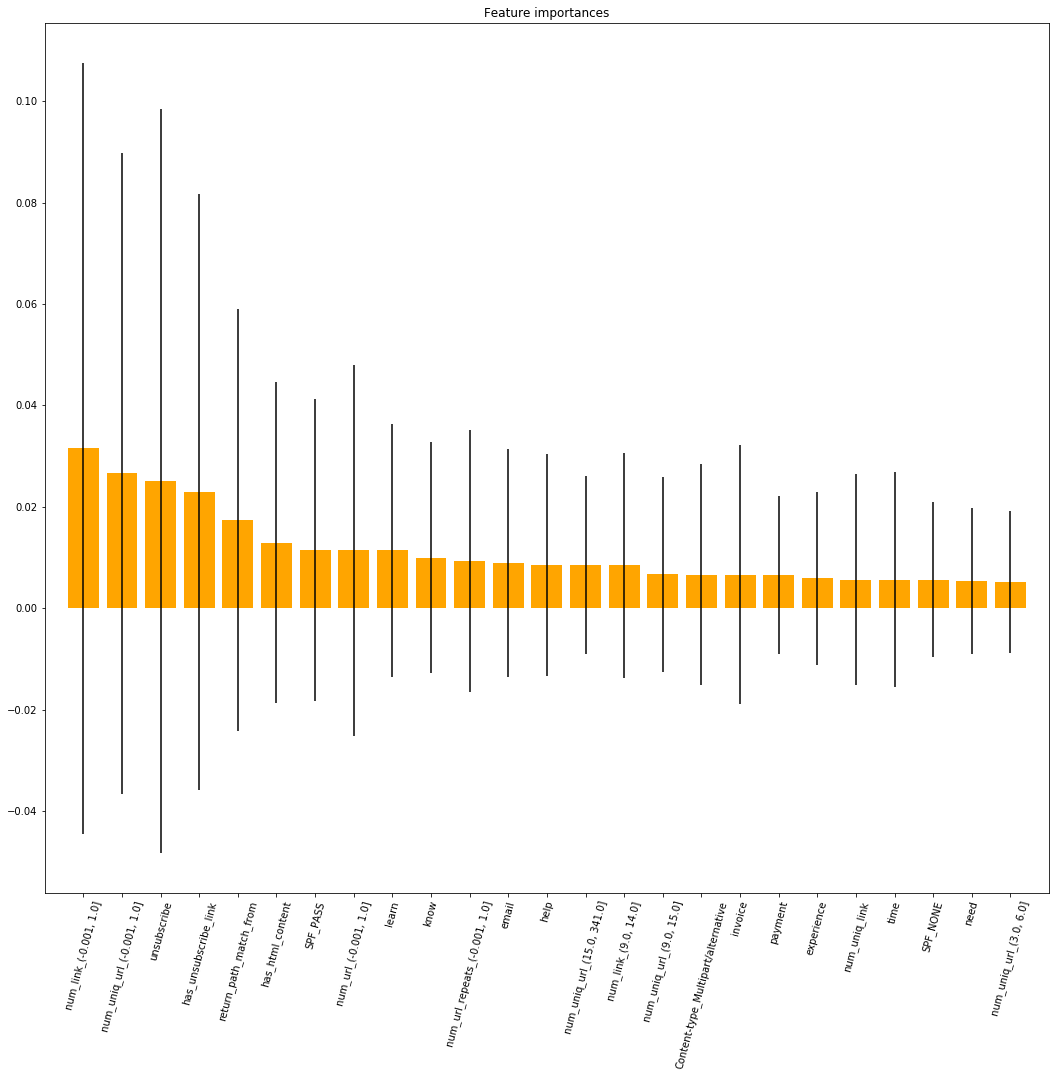

In [40]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="orange", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Neural Net

In [41]:
t0 = time()
nn_clf = MLPClassifier(max_iter=1200,hidden_layer_sizes=(50, 50, 50),learning_rate='adaptive')
nn_clf.fit(train_feats_scaled, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats_scaled,train_labels,test_feats_scaled,test_labels,nn_clf)

done in 3.553s
MLPClassifier Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9554
F1 score: 0.9548
Recall score: 0.986667
False Negatives: 1


#### VotingClassifier

In [42]:
t0 = time()
vt_clf = VotingClassifier(estimators=[
    ('et',et_clf),
    ('svm',svm_clf),
    ('nn',nn_clf),
],voting='hard')
vt_clf.fit(train_feats_scaled, train_labels)
print("done in %0.3fs" % (time() - t0))

done in 2.830s


In [43]:
already_seen = vt_clf.score(train_feats_scaled, train_labels)
accuracy = vt_clf.score(test_feats_scaled, test_labels)
vt_pred = vt_clf.predict(test_feats_scaled)
f1 = f1_score(test_labels, vt_pred, pos_label='investigate')
recall = recall_score(test_labels, vt_pred, pos_label='investigate')
cnf_matrix = confusion_matrix(test_labels, vt_pred)
FN = cnf_matrix[1][0]
false_negative = cnf_matrix[1][0]
print('VotingClassifier Scores:\n')
print('Accuracy of data already seen: %0.4f' % already_seen)
print('Accuracy of data not seen: %0.4f' % accuracy)
print('F1 score: %0.4f' % f1)
print('Recall score: %0.4f' % recall)
print('False Negatives: %0d' % FN)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


VotingClassifier Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9554
F1 score: 0.9548
Recall score: 0.9867
False Negatives: 1


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Best Classifier Scores

In [44]:
print('Best Accuracy:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['accuracy'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest F1 Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['f1'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest Recall Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['recall'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)    
print('\n\nBest False Negative Classifier:\n')
for i in [
    '%s: %i' % (k,v)
    for k,v in sorted(score_dict['FN'], key=lambda tup: tup[1])
    ][:3]:
    print(i)

Best Accuracy:

ExtraTreesClassifier: 0.9618
MLPClassifier: 0.9554
LinearSVC: 0.9363


Best F1 Score:

ExtraTreesClassifier: 0.9610
MLPClassifier: 0.9548
LinearSVC: 0.9359


Best Recall Score:

ExtraTreesClassifier: 0.9867
MLPClassifier: 0.9867
LinearSVC: 0.9733


Best False Negative Classifier:

ExtraTreesClassifier: 1
MLPClassifier: 1
LinearSVC: 2


#### Confusion Matrix and ROC curves of Top Algos

In [45]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [46]:
def display_conf_mat(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    pred = clf.predict(test_feats)
    cnf_matrix = confusion_matrix(test_labels, pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5, 4))
    plot_confusion_matrix(cnf_matrix, classes=['ignore','investigate'],
                          title=clf_name + ' Confusion matrix')
    plt.show()   

In [47]:
#https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/
#https://plot.ly/scikit-learn/plot-roc/
def plot_roc_curve(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    # Binarize the output
    pred = clf.predict(test_feats)
    test_labels_bin = label_binarize(test_labels, classes=['ignore','investigate'])
    pred_bin = label_binarize(pred, classes=['ignore','investigate'])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels_bin, pred_bin)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title(clf_name + ' Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
        label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

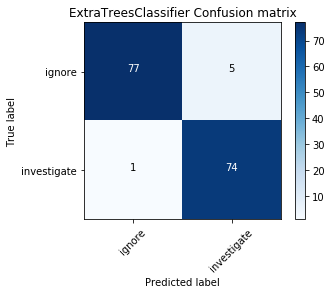

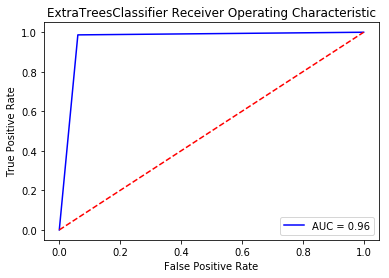

In [48]:
display_conf_mat(et_clf,test_feats_scaled,test_labels)
plot_roc_curve(et_clf,test_feats_scaled,test_labels)

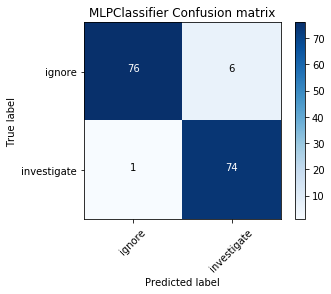

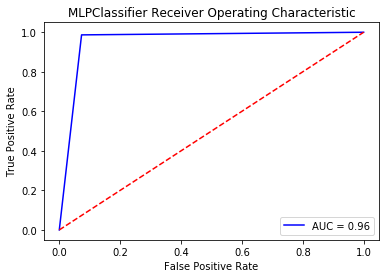

In [49]:
display_conf_mat(nn_clf,test_feats_scaled,test_labels)
plot_roc_curve(nn_clf,test_feats_scaled,test_labels)

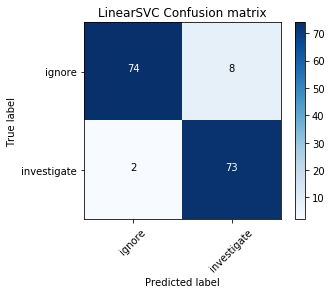

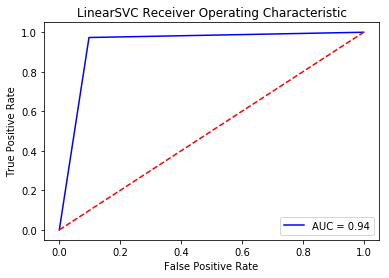

In [50]:
display_conf_mat(svm_clf,test_feats_scaled,test_labels)
plot_roc_curve(svm_clf,test_feats_scaled,test_labels)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


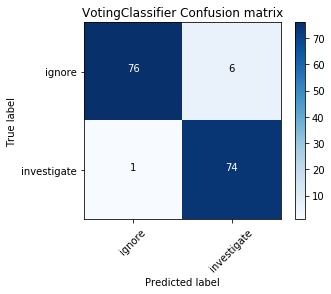

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


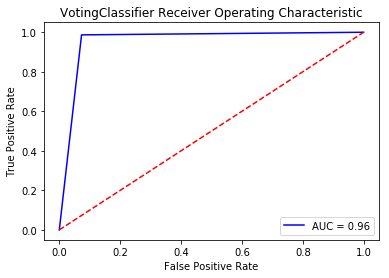

In [51]:
display_conf_mat(vt_clf,test_feats_scaled,test_labels)
plot_roc_curve(vt_clf,test_feats_scaled,test_labels)